<hr style="height:2px;">

# Computational quantitative phase imaging from focal stacks 

In this tutorial we will use Pycro-Manager to compute 2D quantitative phase images from collected focal stacks, without the need for specialized optics, by using computational imaging. Specifically, we will solve and inverse problem based on the [Transport of Intensity Equation (TIE)](https://en.wikipedia.org/wiki/Transport-of-intensity_equation). There are multiple ways of setting up and solving this inverse problem. In this example we will demonstrate how to solve it using [exponentially-spaced Z-planes and a Gaussian process regression solver](https://www.osapublishing.org/oe/fulltext.cfm?uri=oe-22-9-10661&id=284196).

The inverse problem solving code used in this notebook is a translation of Matlab code that can be found [here](https://drive.google.com/a/berkeley.edu/file/d/0B_HY5ZswCff-cU8zWnFnZ3hIa1k/view?usp=sharing)


<hr style="height:2px;">

## Part 1: Setup

Create that functions that will be used to solve the inverse problems

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from numpy import fft
from scipy.io import loadmat

# import tensorflow_probability as tfp
from scipy.optimize import fsolve

"""
intensities: defocused intensity stack, np array
z_vec: positions of images
lambda: wavelength
ps: pixel size
zfocus1: focal plane
Nsl: # of samples in Fourier space
"""


def GP_TIE(Ividmeas, z_vec, lambd, ps, zfocus, Nsl=100, eps1=1, eps2=1, reflect=False):

    # code expects 2D arrays
    if len(z_vec.shape) == 1:
        z_vec = z_vec[:, None]
    if isinstance(ps, float):
        ps = np.array([[ps]])
    elif len(ps.shape) == 1:
        ps = ps[:, None]

    RePhase1 = RunGaussianProcess(
        Ividmeas, zfocus, z_vec, lambd, ps, Nsl, eps1, eps2, reflect
    )
    RePhase1 = RePhase1 / np.mean(Ividmeas)
    #     print("rephase1: ", RePhase1)
    #     print("norm: ", np.mean(Ividmeas))
    return RePhase1


def RunGaussianProcess(Ividmeas, zfocus, z_vec, lambd, ps, Nsl, eps1, eps2, reflect):

    (Nx, Ny, Nz) = Ividmeas.shape
    I0 = Ividmeas[:, :, zfocus]
    zfocus = z_vec[zfocus]

    ### Calculate S_c ###

    # why is dz=1
    freqs = CalFrequency(Ividmeas[:, :, 0], lambd, ps, 1)
    max_freq = np.max(freqs)
    max_freq = np.sqrt(max_freq / (lambd / 2))
    freq_cutoff = np.linspace(0, 1, Nsl) * max_freq
    freq_cutoff = freq_cutoff ** 2 * lambd / 2

    SigmafStack = np.zeros((Nsl, 1))
    SigmanStack = np.zeros((Nsl, 1))
    SigmalStack = np.zeros((Nsl, 1))

    freq_to_sc = np.linspace(1.2, 1.1, Nsl)
    p = Nz / (np.max(z_vec) - np.min(z_vec))

    # Figure out GP regression

    for k in range(Nsl):
        Sigman = 10.0 ** -9
        Sigmaf = 1.0

        f1 = freq_cutoff[k]
        sc = f1 * freq_to_sc[k]
        a = sc ** 2 * 2 * np.pi ** 2
        b = np.log((p * (2 * np.pi) ** 0.5) / Sigman)

        def fu2(x):
            return a * np.exp(x) - 0.5 * x - b

        x = fsolve(fu2, 5)
        Sigmal = np.exp(x)

        SigmafStack[k] = Sigmaf
        SigmanStack[k] = Sigman
        SigmalStack[k] = Sigmal
    # print("SigmafStack: ", SigmafStack)
    # print("SigmanStack: ", SigmanStack)
    # print("SigmalStack: ", SigmalStack)

    dIdzStack = np.zeros((Nx, Ny, Nsl))
    CoeffStack = np.zeros((Nz, Nsl))
    Coeff2Stack = np.zeros((Nz, Nsl))
    for k in range(Nsl):
        Sigmal = SigmalStack[k]
        Sigman = SigmanStack[k]
        Sigmaf = SigmafStack[k]

        ### GP Regression step
        dIdz, Coeff, Coeff2 = GPRegression(
            Ividmeas, zfocus, z_vec, Sigmaf, Sigmal, Sigman
        )
        #         print("dIdz: ", dIdz)
        dIdzStack[:, :, k] = 2 * np.pi / lambd * ps ** 2 * dIdz
        CoeffStack[:, k] = Coeff
        Coeff2Stack[:, k] = Coeff2

    dIdzC = CombinePhase(dIdzStack, freq_cutoff, freqs, CoeffStack, Coeff2Stack)

    # print("dIdzStack: ", dIdzStack)
    # print("CoeffStack: ", CoeffStack)
    # print("Coeff2Stack: ", Coeff2Stack)
    ### poisson solver

    Del2_Psi_xy = (-2 * np.pi / lambd) * dIdzC

    N = dIdzC.shape[0]
    Psi_xy = poisson_solve(Del2_Psi_xy, ps, eps1, 0, reflect)

    #     print("Psi_xy: ", Psi_xy)

    Grad_Psi_x, Grad_Psi_y = np.gradient(Psi_xy / ps)
    Grad_Psi_x = Grad_Psi_x / (I0 + eps2)
    Grad_Psi_y = Grad_Psi_y / (I0 + eps2)
    #     print("Grad_Psi_x: ", Grad_Psi_x.shape)

    grad2x, _ = np.gradient(Grad_Psi_x / ps)
    _, grad2y = np.gradient(Grad_Psi_y / ps)
    Del2_Psi_xy = grad2x + grad2y
    #     print("Del2_Psi_xy: ", Del2_Psi_xy.shape)

    Phi_xy = poisson_solve(Del2_Psi_xy, ps, eps1, 1, reflect)
    #     print("Phi_xy: ", Phi_xy.shape)

    dcval = (
        np.sum(Phi_xy[:, 0])
        + np.sum(Phi_xy[0, :])
        + np.sum(Phi_xy[N - 1, :])
        + np.sum(Phi_xy[:, N - 1])
    ) / (4 * N)

    RePhase = -1 * (Phi_xy - dcval)
    # print("dIdzC: ", dIdzC.shape)
    # print("Del2_Psi_xy: ", Del2_Psi_xy.shape)
    # print("Phi_xy: ", Phi_xy.shape)
    # print("dcval: ", dcval.shape)
    # print("rephase: ", RePhase.shape)
    return RePhase


def CalFrequency(img, lambd, ps, dz):
    (nx, ny) = img.shape

    dfx = 1 / nx / ps
    dfy = 1 / ny / ps

    (Kxdown, Kydown) = np.mgrid[-nx // 2 : nx // 2, -ny // 2 : ny // 2]

    Kxdown = Kxdown * dfx
    Kydown = Kydown * dfy

    freqs = lambd * np.pi * (Kxdown ** 2 + Kydown ** 2)

    # normalized for sampling step and GP Regression ?
    freqs = freqs * dz / (2 * np.pi)

    return freqs


def CombinePhase(dIdzStack, Frq_cutoff, freqs, CoeffStack, Coeff2Stack):
    def F(x):
        return fft.ifftshift(fft.fft2(fft.fftshift(x)))

    def Ft(x):
        return fft.ifftshift(fft.ifft2(fft.fftshift(x)))

    Nx, Ny, Nsl = dIdzStack.shape

    dIdzC_fft = np.zeros((Nx, Ny))
    Maskf = np.zeros((Nx, Ny))

    f0 = 0
    f1 = 1

    for k in range(Nsl):
        dIdz = dIdzStack[:, :, k]
        dIdz_fft = F(dIdz)

        f1 = Frq_cutoff[k]
        Maskf = np.zeros((Nx, Ny))
        Maskf[np.argwhere((freqs <= f1) & (freqs > f0))] = 1
        f0 = f1
        dIdzC_fft = dIdzC_fft + (dIdz_fft * Maskf)

    return np.real(Ft(dIdzC_fft))


def poisson_solve(func, ps, eps, symm, reflect):
    N = len(func)

    if reflect != 0:
        N = N * 2
        func = np.hstack([func, np.fliplr(func)])
        func = np.vstack([func, np.flipud(func)])

    wx = 2 * np.pi * np.arange(0, N, 1) / N
    fx = 1 / (2 * np.pi * ps) * (wx - np.pi * (1 - N % 2 / N))
    [Fx, Fy] = np.meshgrid(fx, fx)
    func_ft = np.fft.fftshift(np.fft.fft2(func))

    Psi_ft = func_ft / (-4 * np.pi ** 2 * (Fx ** 2 + Fy ** 2 + eps))
    if symm:
        Psi_xy = np.fft.irfft2(np.fft.ifftshift(Psi_ft)[:, 0 : N // 2 + 1])
    else:
        Psi_xy = np.fft.ifft2(np.fft.ifftshift(Psi_ft))

    if reflect != 0:
        N = N // 2
        Psi_xy = np.array(Psi_xy)[:N, :N]
    #     print("Psi_ft: ", Psi_ft.shape, "Psi_xy: ", Psi_xy.shape)
    return Psi_xy


def mrdivide(A, B):
    # Solves A / B or xA = B
    return A.dot(np.linalg.pinv(B))


def GPRegression(Ividmeas, zfocus, z, Sigmaf, Sigmal, Sigman):
    Nx, Ny, Nz = Ividmeas.shape
    ones = np.ones((Nz, 1))
    KZ = ones.dot(z.T) - z.dot(ones.T)
    #     print("z: ", z)

    K = Sigmaf * (np.exp(-1 / 2 / Sigmal * (KZ ** 2)))
    L = np.linalg.cholesky(K + (Sigman * np.eye(Nz))).T  # why multiplying by I
    z2 = zfocus
    #     print("zfocus: ", zfocus)

    Nz2 = len(z2)
    ones2 = np.ones((Nz2, 1))
    KZ2 = ones * (z2.T) - z * (ones2.T)
    #     print("KZ2: ", KZ2)
    # print("KZ2 stuff: ", ones, z2, z, ones2)

    D = Sigmaf * (np.exp((-1 / 2 / Sigmal) * (KZ2 ** 2))) / -Sigmal * KZ2
    # print("D: ", D)
    # print("KZ2: ", KZ2)
    # print("sigmaf: ", Sigmaf)
    # print("sigmal: ", Sigmal)
    # return
    Coeff = mrdivide(mrdivide(D.T, L), L.T)[0]  # D.T/L/L.T
    # print("D: ", D)
    # print("L: ", L)
    # print("Coeff: ", Coeff)
    D2 = Sigmaf * (np.exp((-1 / 2 / Sigmal) * (KZ2 ** 2)))
    Coeff2 = mrdivide(mrdivide(D2.T, L), L.T)  # D2.T/L/L.T

    dIdz = np.zeros((Nx, Ny))

    for k in range(Nz):
        dIdz = dIdz + Ividmeas[:, :, k].dot(Coeff[k])
    #     print(k)
    #     print(Ividmeas[:,:,k])
    #     print(Coeff[k])
    #     print(Ividmeas[:,:,k].dot(Coeff[k]))
    # print("dIdz: ", dIdz)

    return dIdz, Coeff, Coeff2

## Test the function using simulated data 
Test the functions using simulated data, which can be accessed [here](https://drive.google.com/a/berkeley.edu/file/d/0B_HY5ZswCff-cU8zWnFnZ3hIa1k/view?usp=sharing)

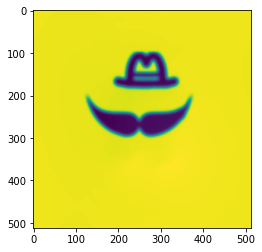

In [2]:
test_path = "phase_rec_GUI/datasets/moustache_man_stack.mat"

data = loadmat(test_path)
Ividmeas = data["Istack"]
z_vec = np.ravel(data["zvec"])

lambd = data["lambda"][0][0]
ps = data["ps"]
zfocus = 1
Nsl = 100

phase = GP_TIE(Ividmeas.astype(np.float), np.ravel(z_vec), lambd, ps, zfocus)
# print("phase: ", phase)
plt.imshow(phase)
# plt.hist(np.ravel(phase))
plt.show()

<hr style="height:2px;">

## Part 2: Implement as a Pycro-manager image processor
be sure to turn debug mode off when running on actual hardware. This example will NOT work in non-debug mode with the micro-manager demo config, because an array of all zeros will be output

In [3]:
import copy

import numpy as np

from pycromanager import Acquisition, multi_d_acquisition_events

planes_per_z_stack = 5
lambd = 6.328e-07  # wavelength of the illumination light, in meters
debug = True  # compute the phase image form test data in previous cell

# This image processor will run each time an image is acquired. If the image is the last one
# in the z-stack, the inverse problem will be solved, and the result added to the GUI. Otherwise
# the image will be accumulated into a temporary list
def img_process_fn(image, metadata):

    # accumulate images as they come
    if not hasattr(img_process_fn, "images"):
        img_process_fn.images = []
        img_process_fn.z_positions = []

    # add pixels and z position
    img_process_fn.images.append(image)
    img_process_fn.z_positions.append(metadata["ZPosition_um_Intended"])

    if metadata["Axes"]["z"] == planes_per_z_stack - 1:
        # its the final one in the z stack

        z_positions = np.array(img_process_fn.z_positions)
        images = np.stack(img_process_fn.images, axis=2).astype(np.float)

        # the z position that is solved for -- assume this is the median of the z-stack (i.e. its symmetrical)
        solved_plane_index = np.argmin(np.abs(z_positions - np.median(z_positions)))

        if debug:
            # debugging -- send in the test data instead
            phase_img = GP_TIE(
                Ividmeas.astype(np.float), np.ravel(z_vec), lambd, ps, zfocus
            )
        else:
            phase_img = GP_TIE(
                images,
                z_positions,
                lambd,
                1e-6 * metadata["PixelSizeUm"],
                solved_plane_index,
            )

        # rescale to 16 bit, since the viewer doesn't accept 32 bit floats
        phase_img = (
            ((phase_img - np.min(phase_img)) / (np.max(phase_img) - np.min(phase_img)))
            * (2 ** 16 - 1)
        ).astype(">u2")

        # create new metadta to go along with this phase image
        phase_image_metadata = copy.deepcopy(metadata)
        # make it appear as a new channel
        phase_image_metadata["Channel"] = "Phase"
        # Put it the z index closest to the solved plane
        phase_image_metadata["Axes"]["z"] = solved_plane_index

        # reset in case multiple z-stacks
        img_process_fn.images = []
        img_process_fn.z_positions = []

        # return the original image and the phase image, in a new channel
        return [(image, metadata), (phase_img, phase_image_metadata)]
    else:
        return image, metadata


img_process_fn.images = []
img_process_fn.z_positions = []

with Acquisition(
    directory="/path/to/save", name="acq_name", image_process_fn=img_process_fn
) as acq:
    # Generate the events for a single z-stack
    events = []
    for index, z_um in enumerate(np.linspace(0, 10, planes_per_z_stack)):
        evt = {"axes": {"z": index}, "z": z_um}
        events.append(evt)
    acq.acquire(events)